# Road Risk and Fatality Analysis from Accidents
## BigData Section C

Big Data, Section C Final Project, Fall 2024 <br>
Riya Garg - rg5073 <br>
Yugesh Panta - yp2651 <br>
Preetham Rakshith Prakash - pp2959 <br>

### Imports PySpark for data processing and Matplotlib/Seaborn for data visualization

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

### Creating a SparkSession with deploy mode as client, 4 GB driver memory, 16 GB executor memory, and 4 executor instances

In [2]:
spark = SparkSession.builder.appName("BigData Project").config(
        "spark.submit.deployMode", "client"
    ).config(
        "spark.driver.memory", "4g"
    ).config(
        "spark.executor.memory", "16g"
    ).config(
        "spark.executor.instances", "4"
    ).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/11 13:27:28 INFO SparkEnv: Registering MapOutputTracker
24/12/11 13:27:28 INFO SparkEnv: Registering BlockManagerMaster
24/12/11 13:27:29 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
24/12/11 13:27:29 INFO SparkEnv: Registering OutputCommitCoordinator


In [3]:
spark.version

'3.5.0'

### Check access to HDFS 

In [4]:
hdfs_path = "hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/"
files = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration()) \
    .listStatus(spark._jvm.org.apache.hadoop.fs.Path(hdfs_path))

In [5]:
for file in files:
    print(file.getPath())

hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/.sparkStaging
hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/FARS2015NationalCSV
hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/FARS2016NationalCSV
hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/FARS2017NationalCSV
hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/FARS2018NationalCSV
hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/FARS2019NationalCSV
hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/FARS2020NationalCSV
hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/accidents.csv
hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/assignment-1
hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/assignment-2
hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/data
hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/jupyterhub
hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/mid-term-Ans1
hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/mid-term-Ans3
hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/path
hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/person.csv
hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/persons.csv
hdfs://nyu-dataproc-m/user/pp2959_nyu_ed

In [6]:
hdfs_path = "hdfs://nyu-dataproc-m/user/pp2959_nyu_edu/"

### FARS Data used from 2015-2019, link:https://www.nhtsa.gov/file-downloads?p=nhtsa/downloads/FARS/

In [7]:
FARS = [
    "FARS2015NationalCSV/", "FARS2016NationalCSV/", 
    "FARS2017NationalCSV/", "FARS2018NationalCSV/", 
    "FARS2019NationalCSV/", "FARS2020NationalCSV/"
]

### Features Selected from Accident csv files

In [8]:
accidents_columns = [
    "ST_CASE", # State case id
    "STATE", # State
    "COUNTY", # County
    "CITY", # City
    "DAY", # Day
    "MONTH", # Month
    "DAY_WEEK", # Day of the week
    "YEAR", # Year
    "HOUR", # Hour
    "MINUTE", # Minute 
    "ROUTE", # Route where the accident occurred
    "FUNC_SYS", # Identifies the functional classification of the segment 
    "HARM_EV",  # First harmful event before the crash
    "MAN_COLL",  # The first type of collision in the crash
    "REL_ROAD",  # Location of the crash as it relates to its position within or outside the trafficway 
    "WRK_ZONE",  # Presence and the type of Workzone 
    "LGT_COND",  # Light conditions
    "WEATHER",  # Weather conditions
    "NOT_HOUR",  # EMV Notificationn Hour
    "NOT_MIN",   # EMV Notification Minute
    "ARR_HOUR",  # EMV Arrival hour
    "ARR_MIN",   # EMV Arrival minute
    "FATALS"  # Fatality count
]

### Features Selected from Vehicles csv files

In [9]:
vehicles_columns = [
    "ST_CASE", # Primary state and case id
    "VEH_NO",  # Vechile number relative to ST_CASE
    "NUMOCCS",  # Number of occupants in the vehicle
    "HIT_RUN",  # Hit and run case 
    "MOD_YEAR",  # Identifies the manufacturer’s model year of this vehicle
    "MAKE",  #  Identifies the make (manufacturer) of this vehicle
    "BODY_TYP",  # Identifies the type of vehicle
    "TRAV_SP",  # Travel Speed of the vehicle
    "ROLLOVER",  # Whether the vehicle had a rollover
    "IMPACT1",  # Impact type of the vehicle
    "DEFORMED",  # Whether the vehicle sustained deformation
    "FIRE_EXP",  # Whether the vehicle caught on fire
    "DEATHS"  # Number of deaths in this vehicle 
]

### Features Selected from Persons csv files

In [10]:
persons_columns = [
    "ST_CASE",  # State and case id 
    "VEH_NO",  # Vehcile number this person is occupant of 
    "PER_NO",  # Person number
    "AGE",  # Age of the person
    "SEX",  # Gender of the person
    "PER_TYP",  # Person type, driver, passanger or a pedestrian
    "INJ_SEV",   # The injury severity sustained by this person
    "SEAT_POS",   # The seat position this person was sitting on 
    "REST_USE",  # Had the person used seat bealts or anyother restraint system
    "AIR_BAG",  # Air bags depoyed for this person
    "DRINKING",  # Was the person had alcohol consumption during the crash
    "DRUGS",  # Was the person on any kind of drugs ( prescribed or otherwse )
    "DOA",  # Whether the person died on scene or en-route
    "STR_VEH"  # What vehicle striked this person ( non-motarist )
]

### Processing acccident, vehicle and person datasets from 2015-2019

In [11]:
def get_dfs(file_type, columns):
    
    dfs = []
    
    for far_file in FARS:
        print('processing : ', far_file)
        dfs.append(
            spark.read.csv(hdfs_path + far_file + file_type, header = True, inferSchema = True).select(*columns)
        )
    return dfs

In [12]:
acc_dfs_list = get_dfs('*ccident*', accidents_columns)

processing :  FARS2015NationalCSV/


processing :  FARS2016NationalCSV/


processing :  FARS2017NationalCSV/
processing :  FARS2018NationalCSV/


processing :  FARS2019NationalCSV/
processing :  FARS2020NationalCSV/


In [13]:
veh_dfs_list = get_dfs('*ehicle*', vehicles_columns)

processing :  FARS2015NationalCSV/


processing :  FARS2016NationalCSV/


processing :  FARS2017NationalCSV/


processing :  FARS2018NationalCSV/


processing :  FARS2019NationalCSV/


processing :  FARS2020NationalCSV/


In [14]:
per_dfs_list = get_dfs('*erson*', persons_columns)

processing :  FARS2015NationalCSV/


processing :  FARS2016NationalCSV/


processing :  FARS2017NationalCSV/


processing :  FARS2018NationalCSV/


processing :  FARS2019NationalCSV/


processing :  FARS2020NationalCSV/


In [15]:
from pyspark.sql.functions import col

In [16]:
def make_ST_CASE_unique(dfs):
    years = [15, 16, 17, 18, 19, 20]
    for i in range(len(dfs)):
        dfs[i] = dfs[i].withColumn("ST_CASE", col("ST_CASE") + (years[i] * 100000))
        val = dfs[i].select("ST_CASE").first()[0]
        print('st_case example : ', val)
    return dfs

In [17]:
acc_dfs_list = make_ST_CASE_unique(acc_dfs_list)

st_case example :  1510001
st_case example :  1610001
st_case example :  1710001
st_case example :  1810001
st_case example :  1910001
st_case example :  2010001


In [18]:
veh_dfs_list = make_ST_CASE_unique(veh_dfs_list)

st_case example :  1510001
st_case example :  1610001
st_case example :  1710001
st_case example :  1810001
st_case example :  1910001
st_case example :  2010001.0


In [19]:
per_dfs_list = make_ST_CASE_unique(per_dfs_list)

st_case example :  1510001
st_case example :  1610001
st_case example :  1710001
st_case example :  1810001.0
st_case example :  1910001
st_case example :  2010001.0


### Reduce Step to unionize the dataframes

In [20]:
from functools import reduce

def reduce_dfs(dfs):
    df = reduce(lambda df_a, df_b: df_a.union(df_b), dfs)
    return df

In [21]:
acc_df = reduce_dfs(acc_dfs_list)

In [22]:
veh_df = reduce_dfs(veh_dfs_list)

In [23]:
per_df = reduce_dfs(per_dfs_list)

### acc_df(accident dataframe) structure

In [24]:
acc_df.show(5)

+-------+-----+------+----+---+-----+--------+----+----+------+-----+--------+-------+--------+--------+--------+--------+-------+--------+-------+--------+-------+------+
|ST_CASE|STATE|COUNTY|CITY|DAY|MONTH|DAY_WEEK|YEAR|HOUR|MINUTE|ROUTE|FUNC_SYS|HARM_EV|MAN_COLL|REL_ROAD|WRK_ZONE|LGT_COND|WEATHER|NOT_HOUR|NOT_MIN|ARR_HOUR|ARR_MIN|FATALS|
+-------+-----+------+----+---+-----+--------+----+----+------+-----+--------+-------+--------+--------+--------+--------+-------+--------+-------+--------+-------+------+
|1510001|    1|   127|   0|  1|    1|       5|2015|   2|    40|    3|       3|     35|       0|       4|       0|       2|      1|      99|     99|       2|     58|     1|
|1510002|    1|    83|   0|  1|    1|       5|2015|  22|    13|    1|       1|     34|       0|       3|       0|       2|     10|      99|     99|      22|     20|     1|
|1510003|    1|    11|   0|  1|    1|       5|2015|   1|    25|    2|       3|     42|       0|       4|       0|       2|      1|      99| 

### vec_df(vehicle dataframe) structure

In [25]:
veh_df.show(5)

+---------+------+-------+-------+--------+----+--------+-------+--------+-------+--------+--------+------+
|  ST_CASE|VEH_NO|NUMOCCS|HIT_RUN|MOD_YEAR|MAKE|BODY_TYP|TRAV_SP|ROLLOVER|IMPACT1|DEFORMED|FIRE_EXP|DEATHS|
+---------+------+-------+-------+--------+----+--------+-------+--------+-------+--------+--------+------+
|1510001.0|     1|      1|      0|    2003|  12|      31|     55|       0|     12|       6|       0|     1|
|1510002.0|     1|      1|      0|    2006|  49|       4|     70|       1|      6|       6|       0|     1|
|1510003.0|     1|      2|      0|    2008|  20|       4|     80|       1|     12|       6|       1|     1|
|1510004.0|     1|      1|      0|    2005|  12|      31|     75|       0|     12|       6|       0|     1|
|1510005.0|     1|      1|      0|    2006|  69|       3|     15|       1|      3|       6|       0|     1|
+---------+------+-------+-------+--------+----+--------+-------+--------+-------+--------+--------+------+
only showing top 5 rows



### per_df(person dataframe) structure

In [26]:
per_df.show(5)

+---------+------+------+---+---+-------+-------+--------+--------+-------+--------+-----+---+-------+
|  ST_CASE|VEH_NO|PER_NO|AGE|SEX|PER_TYP|INJ_SEV|SEAT_POS|REST_USE|AIR_BAG|DRINKING|DRUGS|DOA|STR_VEH|
+---------+------+------+---+---+-------+-------+--------+--------+-------+--------+-----+---+-------+
|1510001.0|     1|     1| 68|  1|      1|      4|      11|       7|      1|       9|    9|  7|      0|
|1510002.0|     1|     1| 49|  1|      1|      4|      11|       7|     20|       0|    0|  7|      0|
|1510003.0|     1|     1| 31|  1|      1|      4|      11|       7|      1|       1|    9|  7|      0|
|1510003.0|     1|     2| 20|  2|      2|      2|      13|       7|      1|       8|    8|  0|      0|
|1510004.0|     1|     1| 40|  1|      1|      4|      11|       7|     20|       1|    9|  7|      0|
+---------+------+------+---+---+-------+-------+--------+--------+-------+--------+-----+---+-------+
only showing top 5 rows



### Number of records in accident data

In [27]:
acc_df.count()

205187

### Number of records in vehicle data

In [28]:
veh_df.count()

369884

### Number of records in person data

In [29]:
per_df.count()

594005

In [30]:
def save_df(df, name):
    df.coalesce(1).write.csv(name, header = True, mode = 'overwrite')

In [31]:
save_df(acc_df, 'accidents.csv')
save_df(veh_df, 'vehicles.csv')
save_df(per_df, 'persons.csv')

### Caching 

In [32]:
accidents = acc_df.cache()
vehicles = veh_df.cache()
persons = per_df.cache()

### Mapping

In [33]:
def create_mapping_udf(mapping_dict):

    broadcast_dict = spark.sparkContext.broadcast(mapping_dict)
    
    def mapper(value):
        return broadcast_dict.value.get(value, "Unknown")
    
    return F.udf(mapper, "string")

In [34]:
def bar_plot(x, y, x_name, y_name, title, color):
    plt.figure(figsize=(10, 6))
    plt.bar(x, y, color = color)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Fatality Analsysis with respect to States

### Mapping of States

In [35]:
states = {
    1: "Alabama",
    2: "Alaska",
    4: "Arizona",
    5: "Arkansas",
    6: "California",
    8: "Colorado",
    9: "Connecticut",
    10: "Delaware",
    11: "District of Columbia",
    12: "Florida",
    13: "Georgia",
    15: "Hawaii",
    16: "Idaho",
    17: "Illinois",
    18: "Indiana",
    19: "Iowa",
    20: "Kansas",
    21: "Kentucky",
    22: "Louisiana",
    23: "Maine",
    24: "Maryland",
    25: "Massachusetts",
    26: "Michigan",
    27: "Minnesota",
    28: "Mississippi",
    29: "Missouri",
    30: "Montana",
    31: "Nebraska",
    32: "Nevada",
    33: "New Hampshire",
    34: "New Jersey",
    35: "New Mexico",
    36: "New York",
    37: "North Carolina",
    38: "North Dakota",
    39: "Ohio",
    40: "Oklahoma",
    41: "Oregon",
    42: "Pennsylvania",
    43: "Puerto Rico",
    44: "Rhode Island",
    45: "South Carolina",
    46: "South Dakota",
    47: "Tennessee",
    48: "Texas",
    49: "Utah",
    50: "Vermont",
    51: "Virginia",
    52: "Virgin Islands",
    53: "Washington",
    54: "West Virginia",
    55: "Wisconsin",
    56: "Wyoming"
}


In [36]:
map_states = create_mapping_udf(states)

In [37]:
accidents = accidents.withColumn("STATENAME", map_states(F.col("STATE"))).cache()

In [38]:
state_counts = accidents.groupBy('STATENAME').count().orderBy('count', ascending = False)
state_counts.show()

+--------------+-----+
|     STATENAME|count|
+--------------+-----+
|    California|20817|
|         Texas|20098|
|       Florida|17525|
|       Georgia| 8496|
|North Carolina| 8023|
|  Pennsylvania| 6426|
|          Ohio| 6365|
|     Tennessee| 5925|
|      Illinois| 5887|
|      New York| 5728|
|      Michigan| 5640|
|South Carolina| 5637|
|       Arizona| 5376|
|       Alabama| 5211|
|      Missouri| 5121|
|       Indiana| 4709|
|      Virginia| 4565|
|     Louisiana| 4269|
|      Kentucky| 4218|
|   Mississippi| 3699|
+--------------+-----+
only showing top 20 rows



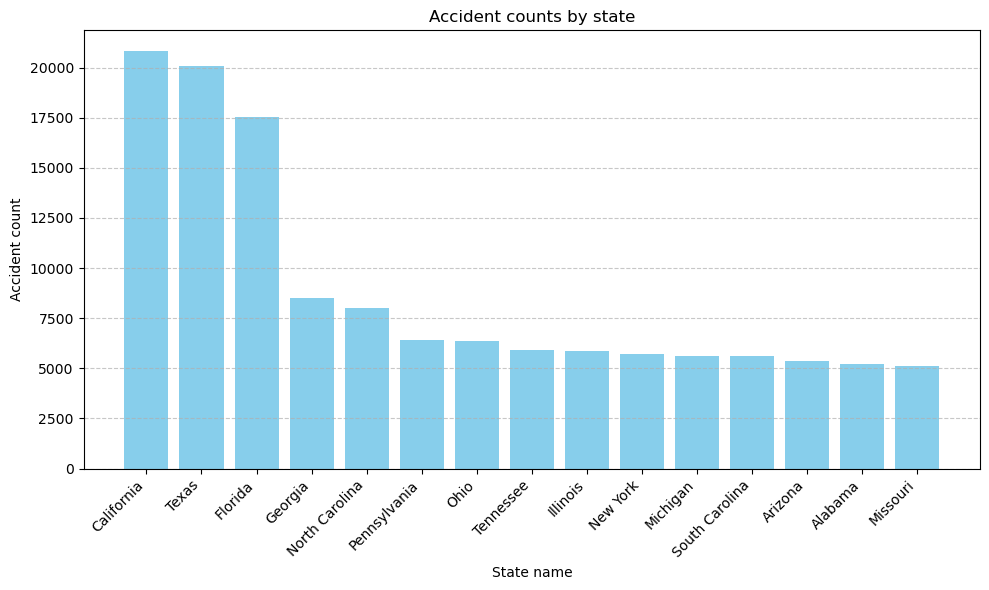

In [39]:
pd = state_counts.toPandas()[:15]
bar_plot(pd['STATENAME'], pd['count'], 'State name', 'Accident count', 'Accident counts by state', 'skyblue')

### The bar plot shows us California to have the highest number of accidents in the US closely followed by Texas and Florida. These numbers may make sense given that California,Texas and Florida are the top 3 states in terms of population in US.
### The interesting obervation is New York (with 4th highest population ) which is not far behind Florida in has significanty less accidents.

## Fatality Analsysis with repect to Road Types

In [40]:
road_types = {
    1: "Interstate",
    2: "U.S. Highway",
    3: "State Highway",
    4: "County Road",
    5: "Local Street (Township)",
    6: "Local Street (Municipality)",
    7: "Local Street (Frontage Road)",
    8: "Other",
    9: "Unknown"
}

In [41]:
map_road_types = create_mapping_udf(road_types)

In [42]:
accidents = accidents.withColumn("ROUTENAME", map_road_types(F.col("ROUTE"))).cache()

+--------------------+-----+
|           ROUTENAME|count|
+--------------------+-----+
|       State Highway|59946|
|Local Street (Mun...|34260|
|        U.S. Highway|33676|
|         County Road|28099|
|          Interstate|25126|
|               Other| 9427|
|             Unknown| 6985|
|Local Street (Tow...| 6220|
|Local Street (Fro...| 1448|
+--------------------+-----+



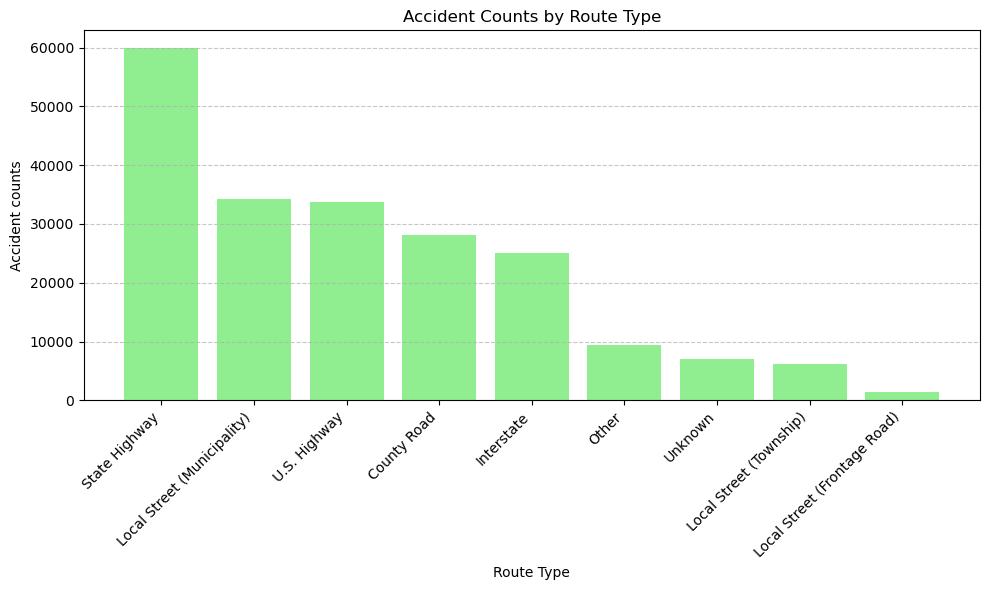

In [43]:
road_counts = accidents.groupBy('ROUTENAME').count().orderBy('count', ascending = False)
road_counts.show()
pd = road_counts.toPandas()
bar_plot(pd['ROUTENAME'], pd['count'], 'Route Type', 'Accident counts', 'Accident Counts by Route Type', 'lightgreen')

### Highest amout of accidents happen on State highways followed by Local Street (Municipality) and US National HIghways.

## Fatality Analsysis with repect to number of Deaths caused by vehicle

+------+------+
|DEATHS| count|
+------+------+
|     0|147571|
|     1|155139|
|     2|  9446|
|     3|  1245|
|     4|   292|
|     5|    64|
|     6|    14|
|     7|     2|
|     8|     3|
|     9|     1|
|    10|     1|
|    13|     2|
|    18|     1|
+------+------+



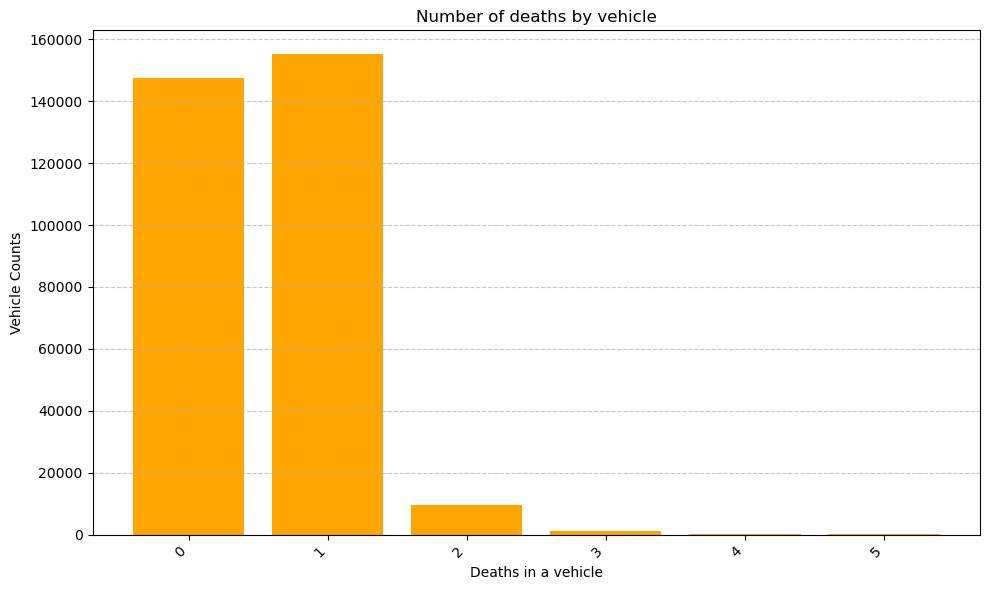

In [44]:
vehicle_deaths = vehicles.filter(vehicles['DEATHS'].isNotNull()).groupBy('DEATHS').count().orderBy('DEATHS', ascending = True)
vehicle_deaths.show()
pd = vehicle_deaths.toPandas()[:6]
bar_plot(pd['DEATHS'], pd['count'], 'Deaths in a vehicle', 'Vehicle Counts', 'Number of deaths by vehicle', 'orange')

### The plot shows that single deaths by vehicle are more common. 

+-------+------+
|NUMOCCS| count|
+-------+------+
|      0|  1490|
|      1|216252|
|      2| 59186|
|      3| 17113|
|      4|  8087|
|      5|  3408|
+-------+------+
only showing top 6 rows



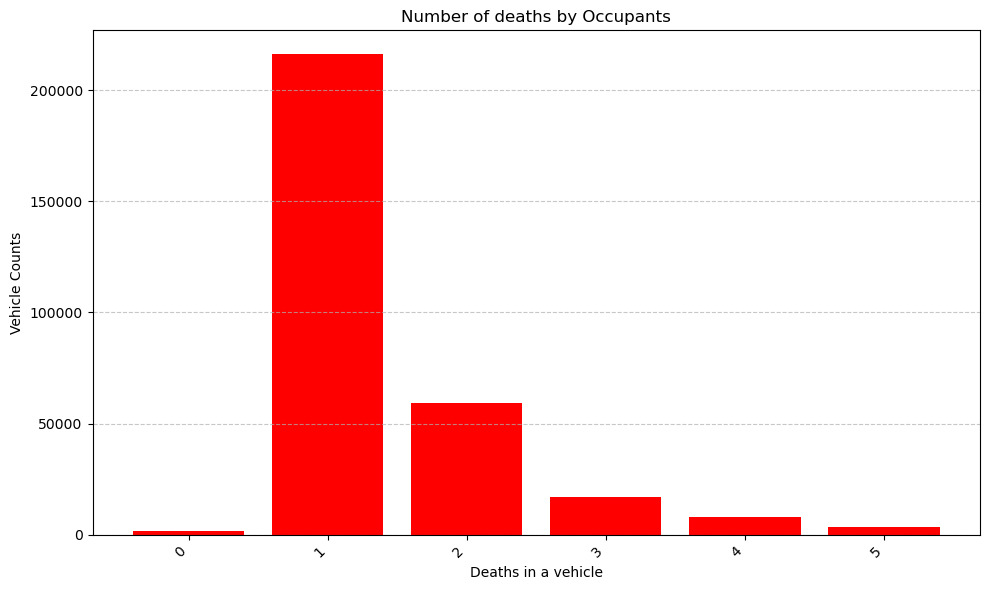

In [45]:
vehicles_cleaned = vehicles.filter(col('NUMOCCS').cast('int').isNotNull())
vehicle_deaths = vehicles_cleaned.groupBy('NUMOCCS').count().orderBy(F.col('NUMOCCS').cast('int'))
vehicle_deaths.show(6)
pd = vehicle_deaths.toPandas()[:6]
bar_plot(pd['NUMOCCS'], pd['count'], 'Deaths in a vehicle', 'Vehicle Counts', 'Number of deaths by Occupants', 'red')

### The plot shows that the number of occupants in a vehicle at the time of a fatal accident. 

## Fatality Analsysis with repect to number of Speed of vehicle

In [46]:
import pandas as pd

In [47]:
veh = vehicles.filter((F.col('TRAV_SP') != 998) & (F.col('TRAV_SP') != 999))
veh = veh.withColumn('TRAV_SP', F.when( F.col('TRAV_SP') == 997, 160).otherwise(col('TRAV_SP')))
# veh.show()

In [48]:
def get_binned(travel_speeds):
    bin_size = 10
    travel_speeds = travel_speeds.withColumn("TRAV_SP_Binned", (F.floor(F.col("TRAV_SP") / bin_size) * bin_size))
    binned_counts = travel_speeds.groupBy("TRAV_SP_Binned").sum("count").orderBy("TRAV_SP_Binned")
    return binned_counts.toPandas()

In [49]:

travel_speeds = veh.groupBy('TRAV_SP').count().orderBy('TRAV_SP', ascending = True)
travel_speeds_deaths = veh.filter(
        (F.col('DEATHS') > 0) & (F.col('DEATHS').isNotNull())
    ).groupBy('TRAV_SP').count().orderBy('TRAV_SP', ascending = True)

binned_counts = get_binned(travel_speeds)
binned_counts_deaths = get_binned(travel_speeds_deaths)

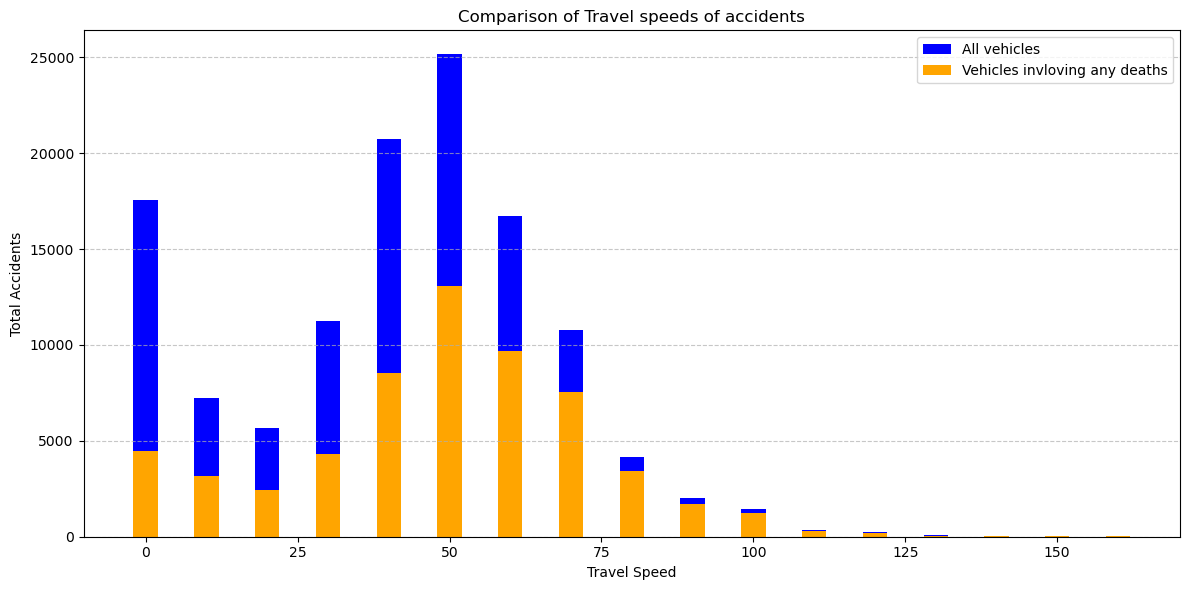

In [50]:

width = 4

plt.figure(figsize=(12, 6))

# Plot the first set of bars
plt.bar(binned_counts['TRAV_SP_Binned'], binned_counts["sum(count)"], width=width, label='All vehicles', color='blue')

# Plot the second set of bars
plt.bar(binned_counts_deaths['TRAV_SP_Binned'], binned_counts_deaths["sum(count)"], width=width, label='Vehicles invloving any deaths', color='orange')

plt.title('Comparison of Travel speeds of accidents')
plt.xlabel('Travel Speed')
plt.ylabel('Total Accidents')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


### Highest amount of accidents happen at 50 mph.  The important observation here is the percentage of death increases with increase in vehicle speed. We can see for example for speed at 50 mph : vehicles without a fatality and vehicles involving deaths is similar but as the speed increases to 100 mph the vehicles incuring a no fatalities is way less than vehicles involving deaths. 

## Fatality Analsysis with repect to number of Drunk Driving

In [51]:
drivers = persons.filter((F.col('PER_TYP') == 1))

In [52]:
drinking_drivers = drivers.filter((F.col('DRINKING') == 1) | (F.col('DRINKING') == 0))
drinking_drivers = drinking_drivers.filter((col('INJ_SEV') >= 0) & (col('INJ_SEV') <= 4))

In [53]:
drinking_deaths = drinking_drivers.groupBy("ST_CASE").agg(
    F.max("DRINKING").alias('DR_DRINK'), F.max('INJ_SEV').alias('INJ_SEV')
)

In [54]:
#drinking_deaths.show(5)

In [55]:
drinking_deaths.groupBy('DR_DRINK').count().show()

+--------+-----+
|DR_DRINK|count|
+--------+-----+
|       1|35384|
|       0|66778|
+--------+-----+



In [56]:
non_drunk_injuries = drinking_deaths.filter(F.col('DR_DRINK') == 0).groupBy('INJ_SEV').count().orderBy('INJ_SEV')

In [57]:
drunk_injuries = drinking_deaths.filter(F.col('DR_DRINK') == 1).groupBy('INJ_SEV').count().orderBy('INJ_SEV')

In [58]:
injury_mapping = {
    '0': "No Injury",
    '1': "Possible Injury (C)",
    '2': "Non-Incapacitating Evident Injury (B)",
    '3': "Incapacitating Injury (A)",
    '4': "Fatal Injury (K)"
}

In [59]:
map_injuries = create_mapping_udf(injury_mapping)

In [60]:
non_drunk_injuries = non_drunk_injuries.withColumn("INJURYTYPE", map_injuries(F.col("INJ_SEV")))
drunk_injuries = drunk_injuries.withColumn("INJURYTYPE", map_injuries(F.col("INJ_SEV")))

+-------+-----+--------------------+----------+
|INJ_SEV|count|          INJURYTYPE|Percentage|
+-------+-----+--------------------+----------+
|      0|16540|           No Injury|     24.77|
|      1| 2936| Possible Injury (C)|       4.4|
|      2| 4386|Non-Incapacitatin...|      6.57|
|      3| 4046|Incapacitating In...|      6.06|
|      4|38870|    Fatal Injury (K)|     58.21|
+-------+-----+--------------------+----------+



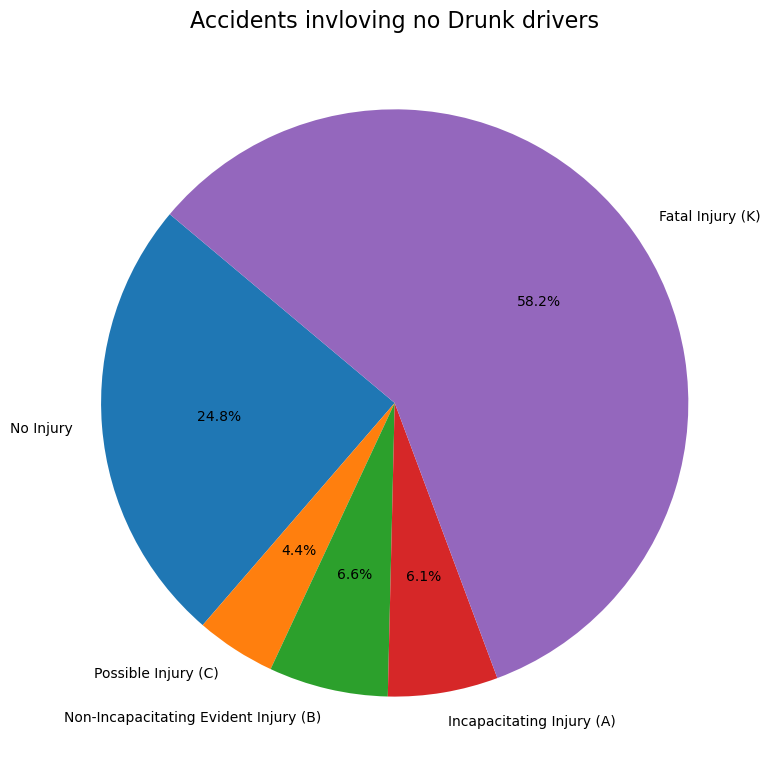

In [61]:
total_count = non_drunk_injuries.select(F.sum(F.col("count"))).collect()[0][0]
non_drunk_per = non_drunk_injuries.withColumn(
    "Percentage", F.round(
            ((F.col("count") / total_count) * 100), 2
        )
    )
non_drunk_per.show()

df = non_drunk_per.toPandas()

# Extract data for plotting
labels = df["INJURYTYPE"]
sizes = df["Percentage"]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=plt.cm.tab10.colors
)

# Customize the chart
plt.title("Accidents invloving no Drunk drivers", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()


### Accidents involving no drunk drivers have 58.2 percent fatal injuries while 24.8 percent are sustained no injuries.

+-------+-----+--------------------+----------+
|INJ_SEV|count|          INJURYTYPE|Percentage|
+-------+-----+--------------------+----------+
|      0| 1861|           No Injury|      5.26|
|      1|  726| Possible Injury (C)|      2.05|
|      2| 1639|Non-Incapacitatin...|      4.63|
|      3| 2084|Incapacitating In...|      5.89|
|      4|29074|    Fatal Injury (K)|     82.17|
+-------+-----+--------------------+----------+



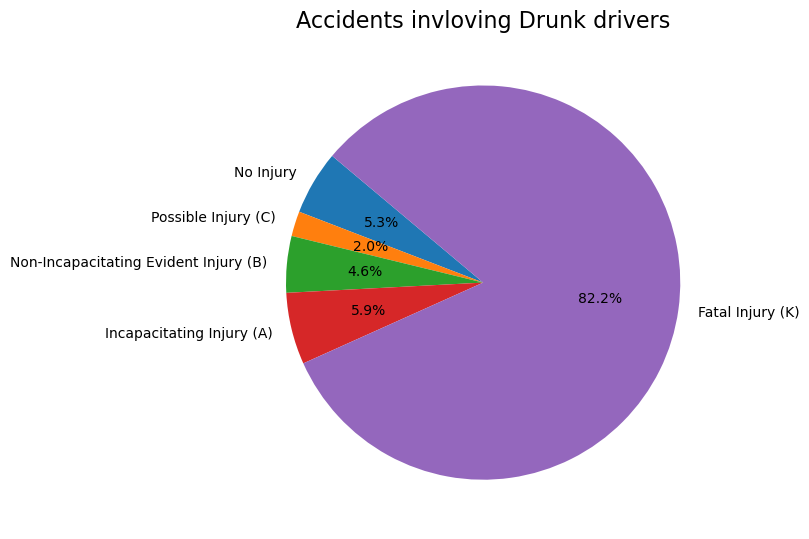

In [62]:
total_count = drunk_injuries.select(F.sum(F.col("count"))).collect()[0][0]
drunk_per = drunk_injuries.withColumn(
    "Percentage", F.round(
            ((F.col("count") / total_count) * 100), 2
        )
    )
drunk_per.show()

df = drunk_per.toPandas()

# Extract data for plotting
labels = df["INJURYTYPE"]
sizes = df["Percentage"]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=plt.cm.tab10.colors
)

# Customize the chart
plt.title("Accidents invloving Drunk drivers", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()


### Accidents involving drunk drivers have 82.2 percent of incuring a fatal injury given an accident, while 5.3 percent probability of incurring no injuries. We can see a significant increase in fatality with accidents having drunk drivers.

In [63]:
age = drivers.filter((F.col('AGE') != 998) & (F.col('AGE') != 999))
age_drunk = age.filter(F.col('DRINKING') == 1)

In [64]:
def get_binned(age):
    bin_size = 10
    age = age.groupBy('AGE').count().orderBy(F.col('AGE').cast('int'))
    age = age.withColumn("Binned", (F.floor(F.col("AGE") / bin_size) * bin_size))
    binned_counts = age.groupBy("Binned").sum("count").orderBy("Binned")
    return binned_counts.toPandas()

In [65]:
binned_counts = get_binned(age)
binned_counts_drunk = get_binned(age_drunk)

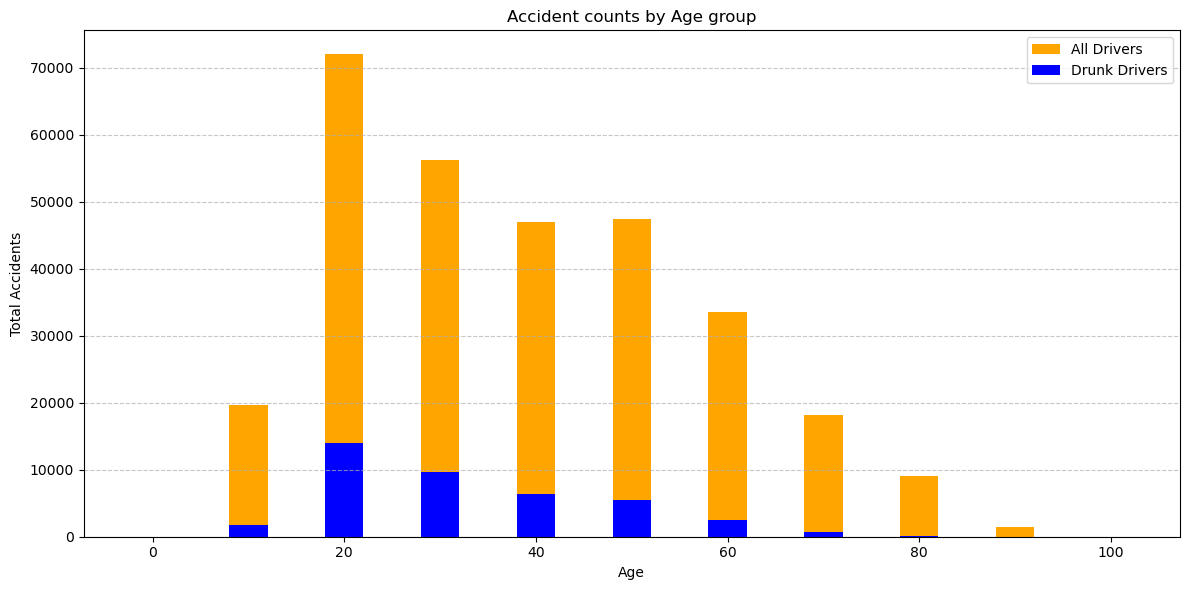

In [66]:
width = 4

plt.figure(figsize=(12, 6))

plt.bar(binned_counts['Binned'], binned_counts["sum(count)"], width=width, label='All Drivers', color='orange')

# Plot the first set of bars
plt.bar(binned_counts_drunk['Binned'], binned_counts_drunk["sum(count)"], width=width, label='Drunk Drivers', color='blue')

plt.title('Accident counts by Age group')
plt.xlabel('Age')
plt.ylabel('Total Accidents')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


### Most accidents involving drunk drivers fall under the age group of 20-30 years.

## Fatality Analsysis with respect to Light conditions

In [67]:
# Load the data (assuming it's already in a DataFrame called accident_df)

# Check distinct values in the LGT_COND column
light_conditions = accidents.select("LGT_COND").distinct()

# Count the number of accidents for each light condition
light_condition_counts = accidents.groupBy("LGT_COND").count().orderBy(F.desc("count"))

# Add human-readable labels based on the codes (using the PDF information)
light_condition_labels = {
    1: "Daylight",
    2: "Dark",
    3: "Dark - Not Lighted",
    4: "Dark - Lighted",
    5: "Dawn",
    6: "Dusk",
    7: "Dark - Unknown Lighting",
    8: "Other",
    9: "Unknown"
}

light_condition_mappings = create_mapping_udf(light_condition_labels)
light_condition_counts = light_condition_counts.withColumn("LGT_COND_LABEL", light_condition_mappings(F.col("LGT_COND")))

# Show the labeled counts
light_condition_counts.select("LGT_COND_LABEL", "count").show()


+--------------------+-----+
|      LGT_COND_LABEL|count|
+--------------------+-----+
|            Daylight|96430|
|                Dark|56457|
|  Dark - Not Lighted|40777|
|                Dawn| 4933|
|      Dark - Lighted| 3916|
|                Dusk| 1503|
|             Unknown|  872|
|               Other|  209|
|Dark - Unknown Li...|   90|
+--------------------+-----+



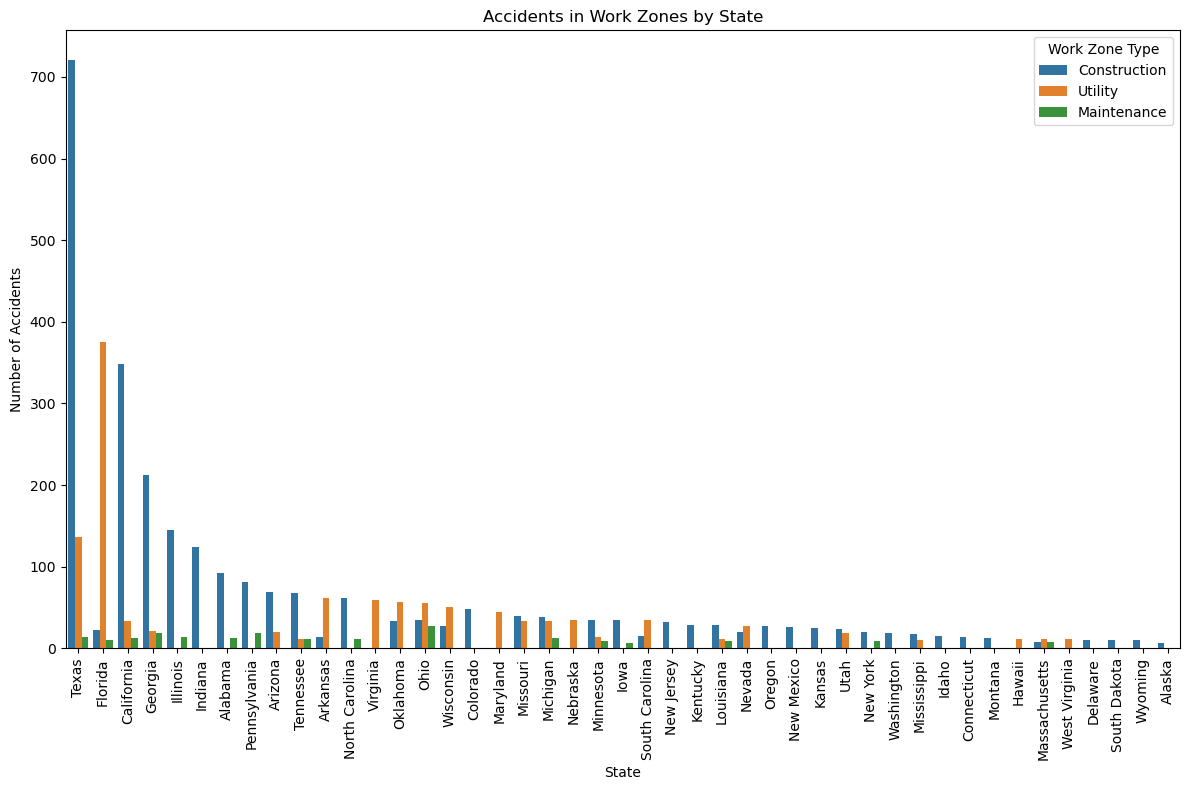

In [68]:
# Define a mapping for WRK_ZONE codes to human-readable labels
work_zone_labels = {
    0: "None",
    1: "Construction",
    2: "Maintenance",
    3: "Construction or Maintenance",
    4: "Utility",
    8: "Not Reported"
}

work_zone_mappings = create_mapping_udf(work_zone_labels)
workzone_accidents = accidents.withColumn("WRK_ZONE_LABEL", work_zone_mappings(F.col("WRK_ZONE")))
workzone_accidents = workzone_accidents.filter(F.col('WRK_ZONE_LABEL') != 'None').groupBy("STATENAME", "WRK_ZONE_LABEL").count()
state_workzone_pd = workzone_accidents.orderBy('count', ascending = False).toPandas()[:80]



plt.figure(figsize=(12, 8))
sns.barplot(data=state_workzone_pd, x="STATENAME", y="count", hue="WRK_ZONE_LABEL")
plt.title("Accidents in Work Zones by State")
plt.xlabel("State")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=90)
plt.legend(title="Work Zone Type")
plt.tight_layout()
plt.show()


### Given the number of accidents where a construction zone was involved, Texas has significantly more number of accidents compared to other states. And Florida has the most number of accidents given a utility work was involved. It is interesting to note that despite having fourth most population, the accidents involving construction is pretty low. 

## Analysis with respect to EMV response time

+--------------------+-----------------+
|           STATENAME|avg_response_time|
+--------------------+-----------------+
|             Wyoming|            18.11|
|          California|            15.36|
|              Oregon|             14.4|
|             Montana|            14.39|
|        North Dakota|             14.2|
|        South Dakota|            13.96|
|          Washington|            13.86|
|                Utah|            13.53|
|               Idaho|             13.5|
|            Oklahoma|            13.29|
|          New Mexico|            12.65|
|             Alabama|            12.62|
|       West Virginia|             12.4|
|            Virginia|            12.28|
|               Maine|            12.13|
|              Alaska|            11.99|
|       New Hampshire|            11.97|
|                Iowa|            11.74|
|            Arkansas|            11.57|
|           Tennessee|            11.54|
|           Louisiana|            11.52|
|            Mar

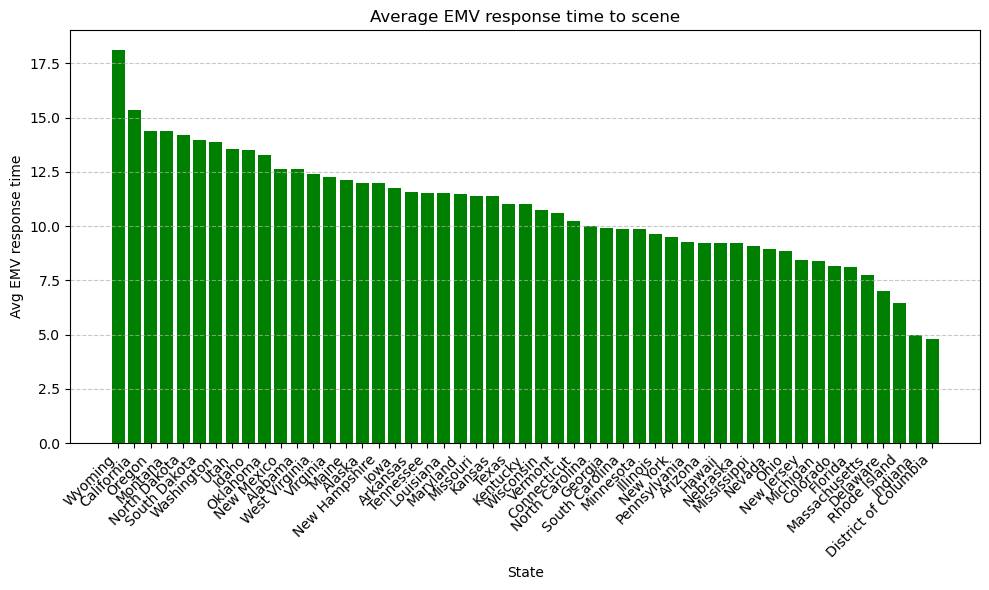

In [69]:
# Filter out invalid or placeholder values (e.g., 99 for hours and minutes)
cleaned_df = accidents.filter(
    (F.col("NOT_HOUR").between(0, 23)) &
    (F.col("NOT_MIN").between(0, 59)) &
    (F.col("ARR_HOUR").between(0, 23)) &
    (F.col("ARR_MIN").between(0, 59))
)

# Calculate time difference in hours
response_time_df = cleaned_df.withColumn(
    "time_to_ems_arrival",
    F.when(
        F.col("ARR_HOUR") >= F.col("NOT_HOUR"),
        (F.col("ARR_HOUR") - F.col("NOT_HOUR")) + (F.col("ARR_MIN") - F.col("NOT_MIN")) / 60
    ).otherwise(
        (24 - F.col("NOT_HOUR") + F.col("ARR_HOUR")) + (F.col("ARR_MIN") - F.col("NOT_MIN")) / 60
    )
)

# Group by state and calculate the average response time
statewise_response_time = response_time_df.groupBy("STATENAME").agg(
    F.round(F.avg("time_to_ems_arrival") * 60, 2).alias("avg_response_time")
).orderBy("avg_response_time", ascending = False)

statewise_response_time.show(57)
# Display the results
pd = statewise_response_time.toPandas()
bar_plot(pd['STATENAME'], pd['avg_response_time'], 'State', 'Avg EMV response time', 'Average EMV response time to scene', 'green')


### Wyoming has the highest Average EMV response time with 18.11 minutes to scene while District of Columbia has the lowest with 4.82 minutes .

## Fatality Analsysis with respect to hour of day

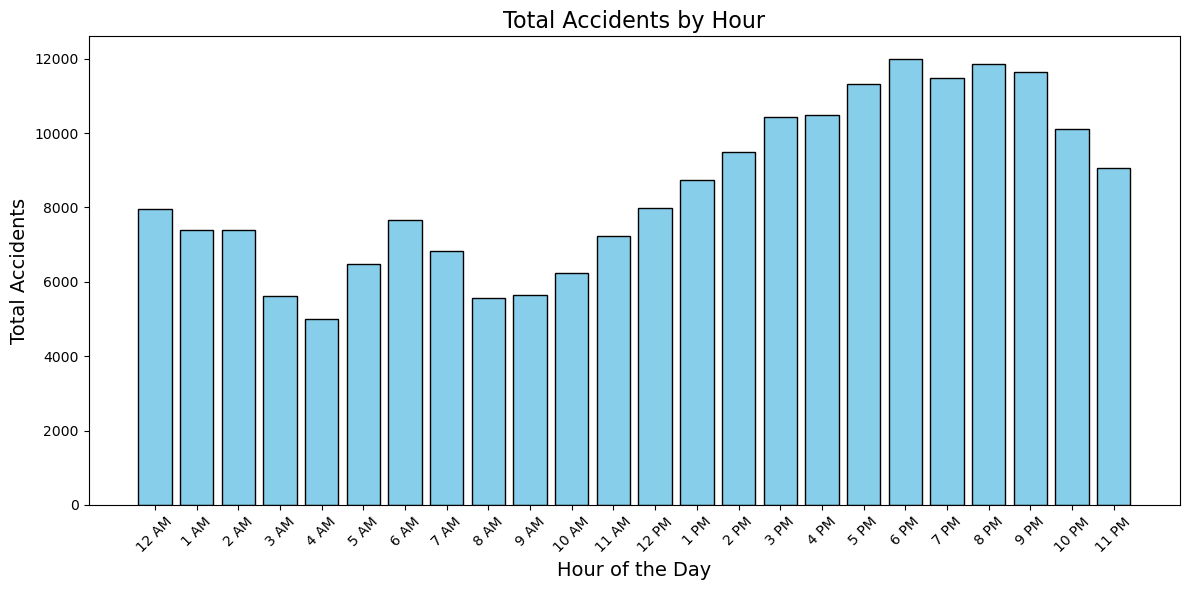

In [70]:

hour_mapping = {
    0: "12 AM", 1: "1 AM", 2: "2 AM", 3: "3 AM", 4: "4 AM", 5: "5 AM", 6: "6 AM", 7: "7 AM", 
    8: "8 AM", 9: "9 AM", 10: "10 AM", 11: "11 AM", 
    12: "12 PM", 13: "1 PM", 14: "2 PM", 15: "3 PM", 16: "4 PM", 17: "5 PM", 18: "6 PM", 
    19: "7 PM", 20: "8 PM", 21: "9 PM", 22: "10 PM", 23: "11 PM", 
    99: "Unknown"
}


accidents_by_hour = accidents.groupBy("HOUR").count().withColumnRenamed("count", "total_accidents").orderBy("HOUR")
accidents_by_hour = accidents_by_hour.filter(F.col("HOUR") != 99)

map_hours = create_mapping_udf(hour_mapping)
accidents_by_hour = accidents_by_hour.withColumn("HOUR_LABEL", map_hours(F.col("HOUR")))

accidents_by_hour = accidents_by_hour.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(accidents_by_hour['HOUR_LABEL'], accidents_by_hour['total_accidents'], color="skyblue", edgecolor="black")

# Customize the plot
plt.title("Total Accidents by Hour", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Total Accidents", fontsize=14)
plt.xticks(accidents_by_hour['HOUR_LABEL'], fontsize=10, rotation = 45)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()



### Most accidents occur around the evening rush hours.

## Fatality Analsysis with repect to Collision Types

+--------------------+-----+
|      MAN_COLL_LABEL|count|
+--------------------+-----+
|Sideswipe ( Oppos...|37132|
|             Head-on|21294|
|            Rear-end|14333|
|             Unknown| 3397|
|Sideswipe (Either...| 3222|
+--------------------+-----+



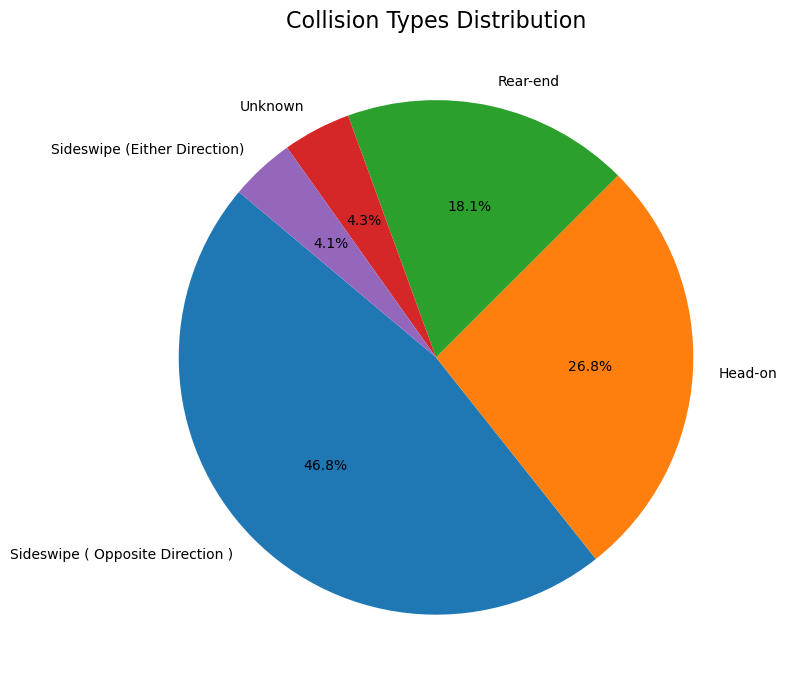

In [71]:
# Manner of collision codes and descriptions
manner_of_collision_mapping = {
    0: "Not Collision With Motor Vehicle", 1: "Rear-end", 2: "Head-on", 3: "Rear-to-Rear",
    4: "Angle", 5: "Sideswipe ( Same Direction )", 6: "Sideswipe ( Opposite Direction )", 7: "Sideswipe (Either Direction)", 9: "Unknown"
}

collision_mapping = create_mapping_udf(manner_of_collision_mapping)
accidents_by_collision = accidents.withColumn("MAN_COLL_LABEL", collision_mapping(F.col("MAN_COLL"))).filter(
        (F.col('MAN_COLL') != 0) & (F.col('MAN_COLL') != 9)
    )

# Count accidents by manner of collision
accidents_by_collision = accidents_by_collision.groupBy("MAN_COLL_LABEL").count().orderBy('count', ascending = False)
accidents_by_collision.show()

df = accidents_by_collision.toPandas()

# Extract data for plotting
labels = df["MAN_COLL_LABEL"]
sizes = df["count"]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=plt.cm.tab10.colors
)

# Customize the chart
plt.title("Collision Types Distribution", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()


### Sideswipe ( Opposite Direction ) and Head-on being collisions responsible for nealy three fourths of the accidents could be a cause of not having dividers. ( Most accidents do not involve a collision and are excluded )

## Fatality Analysis with repect to Pedestrian accidents

+----+--------------------+
|YEAR|pedestrian_accidents|
+----+--------------------+
|2015|                5091|
|2016|                5637|
|2017|                5635|
|2018|                5906|
|2019|                5865|
|2020|                6026|
+----+--------------------+



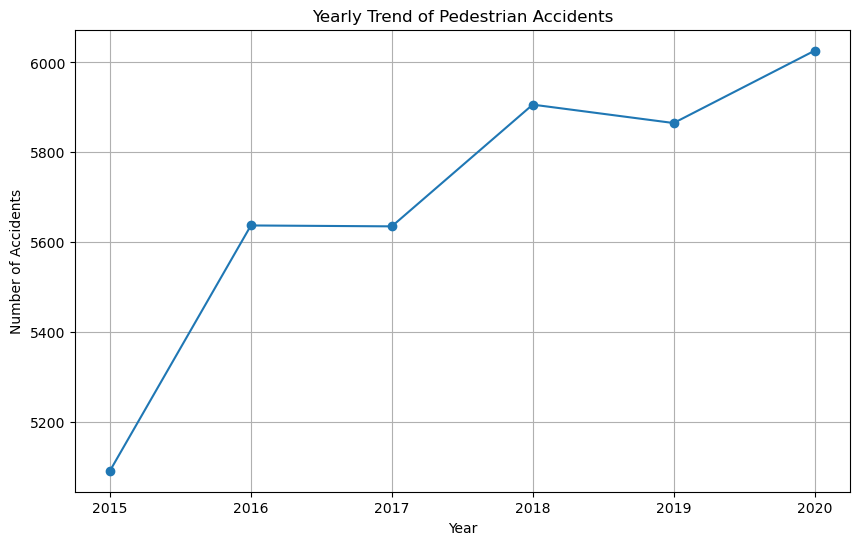

In [72]:
# Filter for 'Pedestrian' accidents (HARM_EV = 8)
pedestrian_trend = (
    accidents.filter(F.col("HARM_EV") == 8)
    .groupBy("YEAR")
    .agg(F.count("*").alias("pedestrian_accidents"))
    .orderBy("YEAR")
)

# Show the results
pedestrian_trend.show(80)

# Convert to Pandas DataFrame for plotting
pedestrian_trend_pd = pedestrian_trend.toPandas()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(pedestrian_trend_pd["YEAR"], pedestrian_trend_pd["pedestrian_accidents"], marker='o')
plt.title("Yearly Trend of Pedestrian Accidents")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.grid(True)
plt.show()


### The number of pedestrian accidents increase yearly. This is cause of concern escpecially combined with the fact that cities and states are legalizing Jaywalking including New York City.

+----+--------------------+---------------+------------------+
|YEAR|pedestrian_accidents|total_accidents|percentage        |
+----+--------------------+---------------+------------------+
|2015|5091                |32538          |15.64632122441453 |
|2016|5637                |34748          |16.222516403821803|
|2017|5635                |34560          |16.30497685185185 |
|2018|5906                |33919          |17.412069931306938|
|2019|5865                |33487          |17.514259264789324|
|2020|6026                |35935          |16.769166550716573|
+----+--------------------+---------------+------------------+



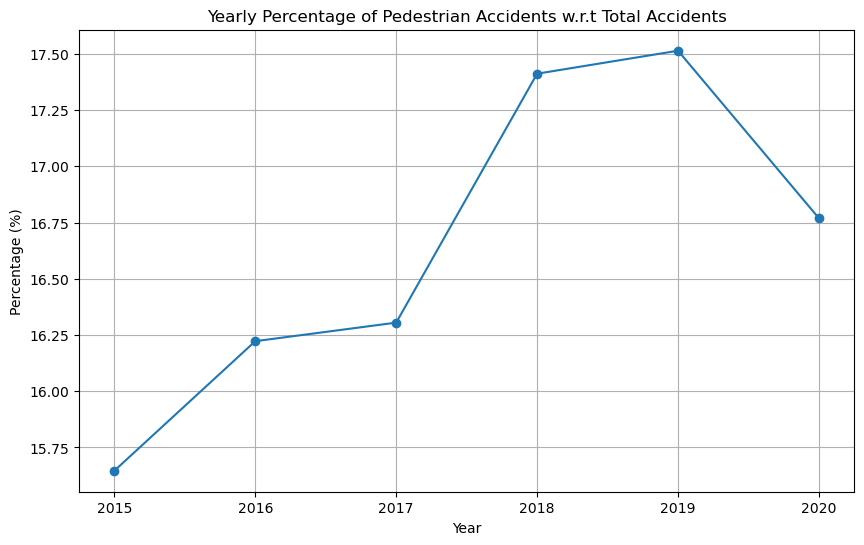

In [73]:
# Calculate total accidents per year
total_accidents_per_year = accidents.groupBy("YEAR").agg(F.count("*").alias("total_accidents"))

# Calculate pedestrian accidents percentage per year
pedestrian_percentage_per_year = (
    accidents.filter(F.col("HARM_EV") == 8)
    .groupBy("YEAR")
    .agg(F.count("*").alias("pedestrian_accidents"))
    .join(total_accidents_per_year, on="YEAR")
    .withColumn("percentage", (F.col("pedestrian_accidents") / F.col("total_accidents")) * 100)
    .orderBy("YEAR")
)

# Show the results
pedestrian_percentage_per_year.show(truncate=False)

# Convert to Pandas DataFrame for plotting
pedestrian_percentage_pd = pedestrian_percentage_per_year.toPandas()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(pedestrian_percentage_pd["YEAR"], pedestrian_percentage_pd["percentage"], marker='o')
plt.title("Yearly Percentage of Pedestrian Accidents w.r.t Total Accidents")
plt.xlabel("Year")
plt.ylabel("Percentage (%)")
plt.grid(True)
plt.show()

### The relative percentage of pedestrian accidents increase yearly baring 2020. 

## Fatality Analsysis with repect to Weather conditions for each state

In [74]:
# Mapping for WEATHER attribute codes
weather_mapping = {
    1: "Clear",
    2: "Rain",
    3: "Sleet (Hail)",
    4: "Snow",
    5: "Fog",
    6: "Smog",
    7: "Sand/Dust",
    8: "Other",
    10: "Cloudy",
    11: "Blowing Snow",
    98: "Not Reported",
    99: "Unknown"
}

weather_mappings = create_mapping_udf(weather_mapping)
accidents = accidents.withColumn("WEATHER_NAME", weather_mappings(F.col("WEATHER"))).cache()



24/12/11 13:29:41 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


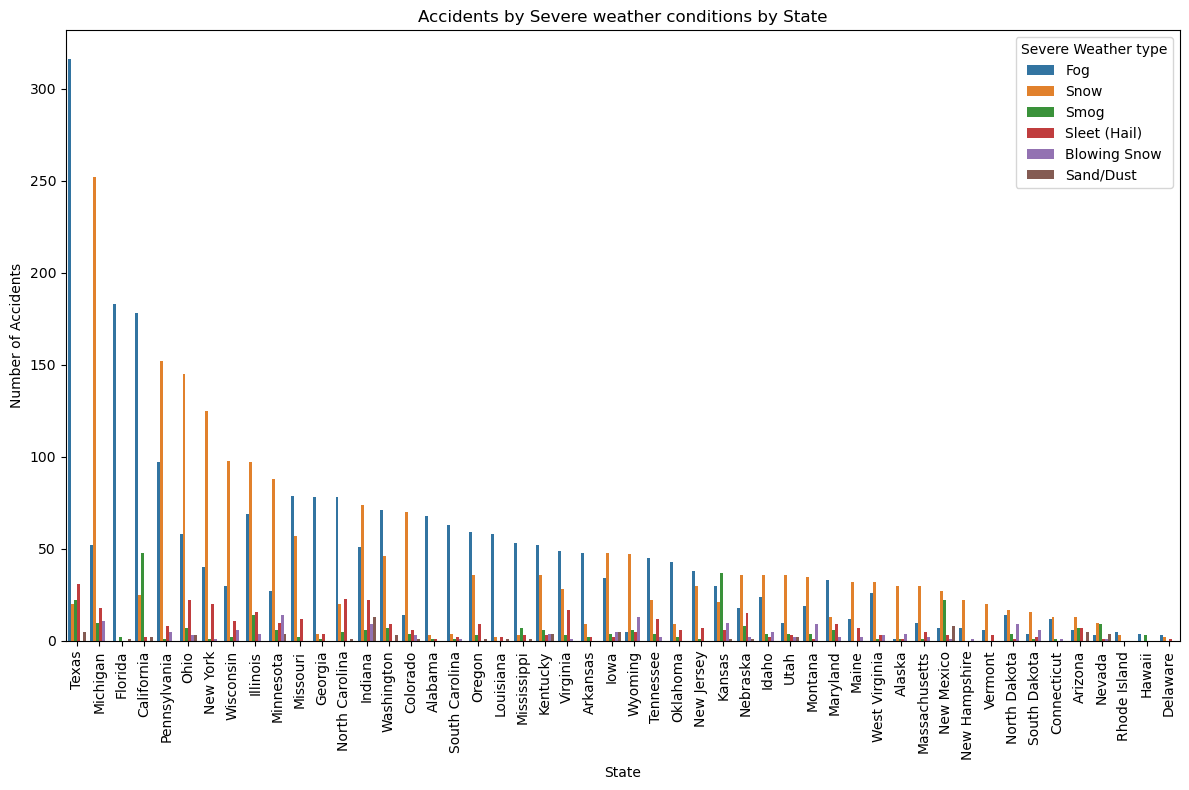

In [75]:
mapped_weather_df = accidents.filter(
        (F.col('WEATHER') != 99) & (F.col('WEATHER') != 98)
    )

mapped_weather_df.groupBy('WEATHER_NAME').count()

# Filter for severe weather conditions
severe_weather_conditions = ["Fog", "Smog", "Snow", "Sleet (Hail)", "Blowing Snow", "Sand/Dust"]
severe_weather_accidents = (
    mapped_weather_df.filter(F.col("WEATHER_NAME").isin(severe_weather_conditions))
    .groupBy("STATENAME", "WEATHER_NAME")
    .agg(F.count("*").alias("accident_count"))
    .orderBy("accident_count", ascending = False)
)

# severe_weather_accidents.show()

pd = severe_weather_accidents.toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(data = pd, x="STATENAME", y="accident_count", hue="WEATHER_NAME")
plt.title("Accidents by Severe weather conditions by State")
plt.xlabel("State")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=90)
plt.legend(title="Severe Weather type")
plt.tight_layout()
plt.show()



### Texas , Florida and California being at top of the list for accidents due to severe weather conditions is not out  of norm due to the fact that they have the highest number of accidents. 
### Michigan's snowy conditions have caused a large amount of accidents and it makes it hard for both drivers and government to tackle this issue.

In [76]:
state_route_weather_analysis = (
    accidents.groupBy("STATENAME", "ROUTENAME", "WEATHER_NAME")
    .count()
    .withColumnRenamed("count", "ACCIDENT_COUNT")
    .orderBy("count")
)


In [77]:
def plot_and_show_table(df, state: int, weather: int):
    """
    Filters the DataFrame and plots a bar chart while also showing the data in a table.

    Parameters:
    df (DataFrame): The state_route_weather_analysis DataFrame.
    state (int): The state code to filter.
    weather (int): The weather condition code to filter.
    """
    # Filter the data
    filtered_df = df.filter((df.STATENAME == state) & (df.WEATHER_NAME == weather))
    
    # Convert to Pandas DataFrame
    pandas_df = filtered_df.toPandas()

    # Check if there is data to plot
    if pandas_df.empty:
        print(f"No data found for state {state} and weather {weather}")
        return

    # Display the table
    print(f"Table for State={state} and Weather={weather}:")
    # display(pandas_df)

    # Plot the data
    plt.figure(figsize=(10, 6))
    sns.barplot(data=pandas_df, x="ROUTENAME", y="ACCIDENT_COUNT", palette="viridis")
    plt.title(f"Accident Counts by Route for State={state}, Weather={weather}")
    plt.xlabel("Route Type")
    plt.ylabel("Accident Count")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()


Table for State=Texas and Weather=Fog:


/tmp/ipykernel_474143/2972686159.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pandas_df, x="ROUTENAME", y="ACCIDENT_COUNT", palette="viridis")


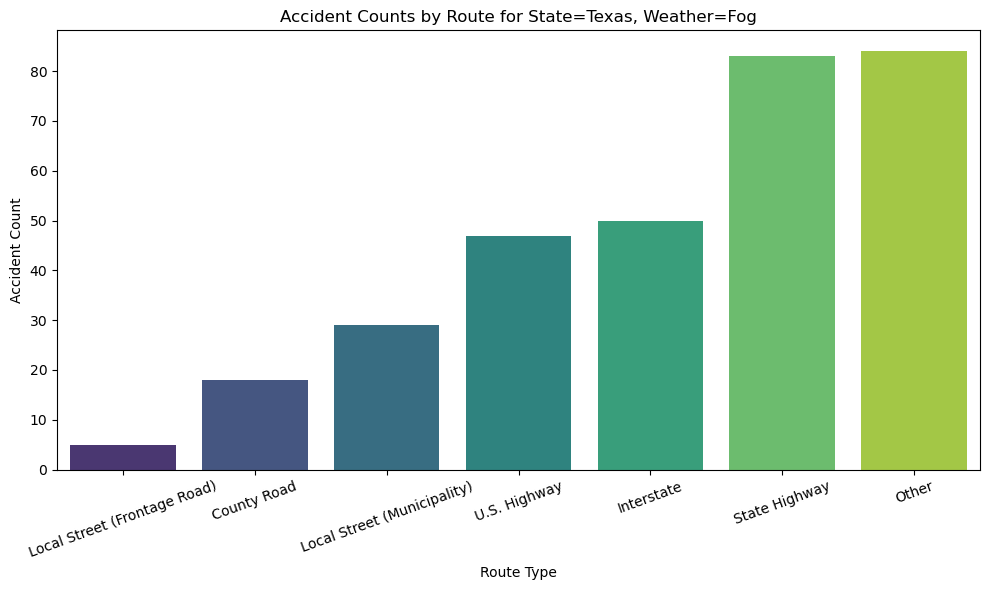

In [78]:
# Plot for Texas and Fog
state = 'Texas'  # Replace with the desired state code
weather = 'Fog'  # Replace with the desired weather code
plot_and_show_table(state_route_weather_analysis, state, weather)

### This plot shows which Route type has high amount of accidents for specific weather condition(Fog) and State(Texas). State Highways are dangeous for this case.

Table for State=Texas and Weather=Fog:


/tmp/ipykernel_474143/2972686159.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pandas_df, x="ROUTENAME", y="ACCIDENT_COUNT", palette="viridis")


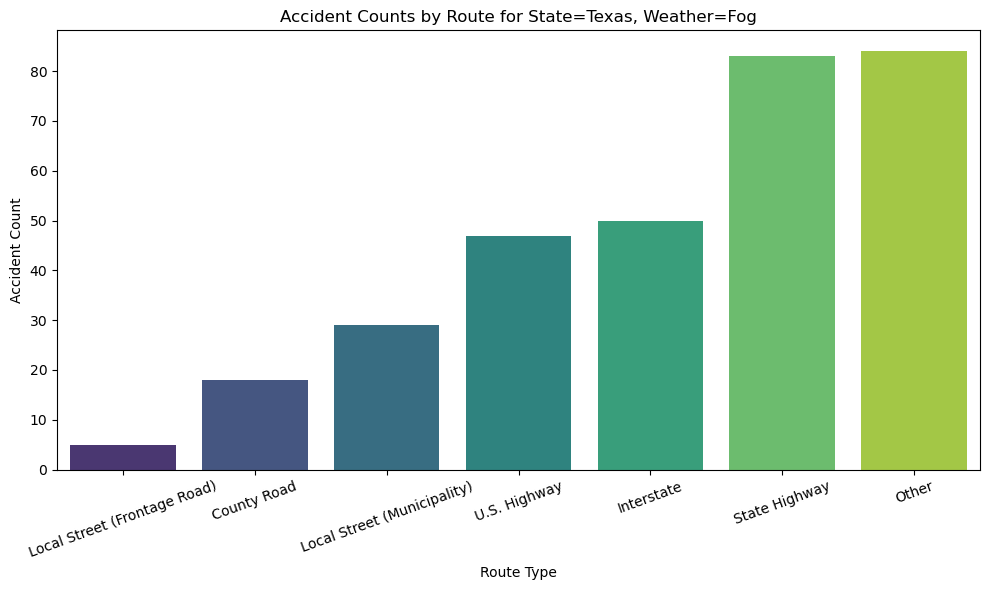

In [79]:
# PLot
state = 'Texas'  # Replace with the desired state code
weather = 'Fog'  # Replace with the desired weather code
plot_and_show_table(state_route_weather_analysis, state, weather)

In [80]:
persons = persons.withColumn("INJURYTYPE", map_injuries(F.col("INJ_SEV"))).cache()

## Fatality Analysis with respect to Vehicle body type

In [81]:
vehicle_body_types = {
    1: "Convertible",
    2: "2-Door Sedan/Coupe",
    3: "2-/3-Door Hatchback",
    4: "4-Door Sedan",
    5: "4-/5-Door Hatchback",
    6: "Station Wagon",
    7: "Hatchback (Doors Unknown)",
    8: "Sedan (Doors Unknown)",
    9: "Other/Unknown Auto Type",
    10: "Auto-Based Pickup",
    11: "Auto-Based Panel",
    12: "Large Limousine",
    13: "Three-Wheel Auto",
    14: "Compact Utility",
    15: "Large Utility",
    16: "Utility Station Wagon",
    17: "3-Door Coupe",
    19: "Unknown Utility Body",
    20: "Minivan",
    21: "Large Van",
    22: "Step Van (< 10,000 lbs)",
    28: "Other Van Type",
    29: "Unknown Van Type",
    30: "Compact Pickup (< 4,500 lbs)",
    31: "Standard Pickup (4.5K to 10K lbs)",
    32: "Pickup w/ Camper",
    33: "Convertible Pickup",
    34: "Light Pickup",
    39: "Unknown Light Truck",
    40: "Cab Chassis-Based",
    41: "Truck-Based Panel",
    42: "Truck Motorhome",
    45: "Other Light Truck",
    48: "Unknown Light Truck",
    49: "Unknown Light Vehicle",
    50: "School Bus",
    51: "Intercity Bus",
    52: "Transit Bus",
    55: "Van-Based Bus (> 10,000 lbs)",
    58: "Other Bus Type",
    59: "Unknown Bus Type",
    60: "Step Van (> 10,000 lbs)",
    61: "Straight Truck (10,001–19,500 lbs)",
    62: "Straight Truck (19,501–26,000 lbs)",
    63: "Straight Truck (> 26,000 lbs)",
    64: "Straight Truck (GVWR Unknown)",
    65: "Medium/Heavy Motorhome",
    66: "Truck/Tractor",
    67: "Heavy Pickup (> 10,000 lbs)",
    71: "Unknown Medium Truck (10,001–26,000 lbs)",
    72: "Unknown Heavy Truck (> 26,000 lbs)",
    73: "Unknown Camper/Truck",
    78: "Unknown Heavy Truck Type",
    79: "Unknown Truck Type",
    80: "2-Wheel Motorcycle",
    81: "Moped",
    82: "3-Wheel Motorcycle",
    83: "Off-Road Motorcycle",
    84: "Motor Scooter",
    85: "Open 3-Wheel Motorcycle",
    86: "Enclosed 3-Wheel Motorcycle",
    87: "Unknown 3-Wheel Motorcycle",
    88: "Other Motored Cycle",
    89: "Unknown Cycle Type",
    90: "ATV",
    91: "Snowmobile",
    92: "Farm Equipment",
    93: "Construction Equipment",
    94: "Low-Speed Vehicle (LSV)",
    95: "Golf Cart",
    96: "Off-Road Vehicle",
    97: "Other Vehicle Type",
    98: "Not Reported",
    99: "Unknown Body Type",
}

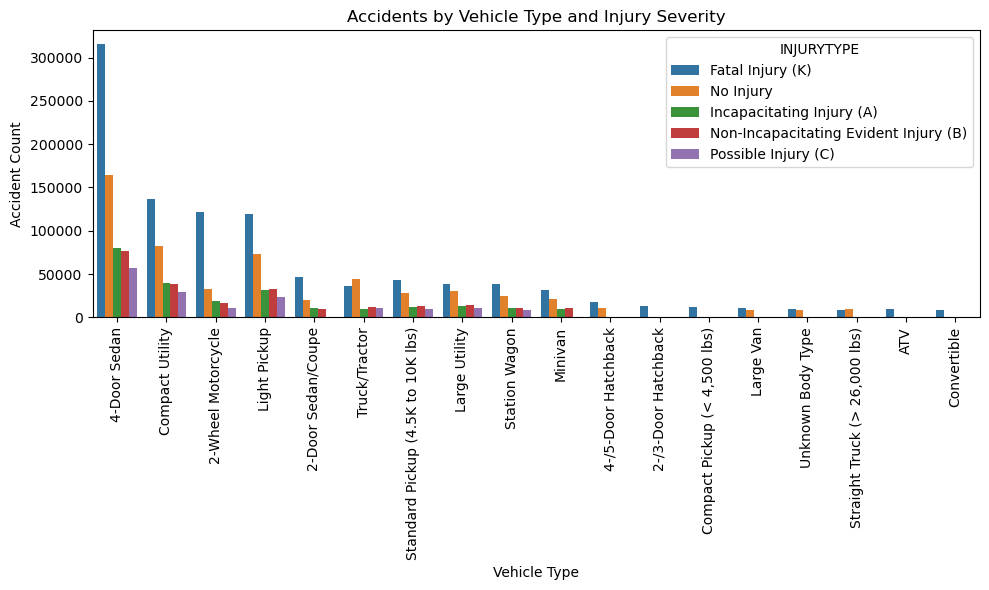

In [82]:
# Accidents by Vehicle Type and Injury Severity
vehicle_severity_analysis = (
    vehicles.join(accidents, "ST_CASE")  # Join vehicle and accident data on ST_CASE
    .join(persons, ["ST_CASE", "VEH_NO"])  # Join with persons data on ST_CASE and VEH_NO
    .groupBy("BODY_TYP", "INJURYTYPE")  # Group by vehicle type and injury severity
    .count()  # Count accidents per group
    .withColumnRenamed("count", "ACCIDENT_COUNT")  # Rename the count column to ACCIDENT_COUNT
)

veh_body_mappings = create_mapping_udf(vehicle_body_types)
vehicle_severity_analysis = vehicle_severity_analysis.withColumn("BODY_TYP_LABEL", veh_body_mappings(F.col("BODY_TYP")))

vehicle_severity_analysis = vehicle_severity_analysis.filter(
        (F.col("BODY_TYP_LABEL") != 'Unknown') & (F.col("INJURYTYPE") != "Unknown")
    )

# Convert to Pandas for easier plotting
vehicle_severity_df = vehicle_severity_analysis.orderBy('ACCIDENT_COUNT', ascending = False).toPandas()

# Plotting the data
plt.figure(figsize=(10, 6))
sns.barplot(data=vehicle_severity_df[:60], x="BODY_TYP_LABEL", y="ACCIDENT_COUNT", hue="INJURYTYPE")
plt.title("Accidents by Vehicle Type and Injury Severity")
plt.xlabel("Vehicle Type")
plt.ylabel("Accident Count")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

### The plot shows Accident count for each type of injury for vehicle type 
### 4-door Sedans are involved in most accidents. 
### Intresting observation is that truck/tractor have lower fatal accients beacuse of the size and build of these vehicles.

In [83]:
def analyze_by_body_type_and_severity(df_pd, body_type, injury_severity_min_count):
    """
    Analyzes the data based on a given vehicle body type and injury severity.
    
    Parameters:
    - df (DataFrame): The input DataFrame containing vehicle severity data.
    - body_type (int): The vehicle body type to filter the data by.
    - injury_severity_min_count (int): The minimum count of accidents required for a given injury severity.
    
    Returns:
    - pd.DataFrame: A cleaned and filtered Pandas DataFrame with percentages.
    """
    
    # Filter the data for the specified body type
    df_filtered = df_pd[df_pd["BODY_TYP_LABEL"] == body_type]
    
    df_filtered = df_filtered[df_filtered["ACCIDENT_COUNT"] > 0]  # Remove rows with zero accident count

    # Group by 'INJ_SEV' and sum the accident counts
    severity_counts = df_filtered.groupby("INJURYTYPE")["ACCIDENT_COUNT"].sum().reset_index()
    
    # Calculate the total accident count for the body type
    total_accidents = severity_counts["ACCIDENT_COUNT"].sum()
    
    # Calculate percentages
    severity_counts["PERCENTAGE"] = (severity_counts["ACCIDENT_COUNT"] / total_accidents) * 100
    
    # Plot Pie Chart: Accident Count by Injury Severity for the given body type
    plt.figure(figsize=(8, 6))
    plt.pie(severity_counts["ACCIDENT_COUNT"], labels=severity_counts["INJURYTYPE"], autopct='%1.1f%%', startangle=90)
    plt.title(f"Distribution of Accidents by Injury Severity for Body Type {body_type}")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


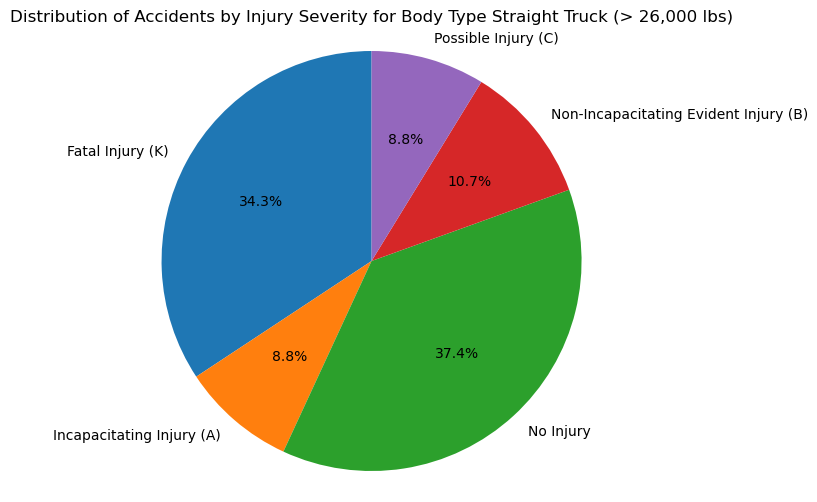

In [84]:
# Usage example
body_type = 'Straight Truck (> 26,000 lbs)'  # Example body type, you can replace it with any valid body type
analyze_by_body_type_and_severity(vehicle_severity_df, body_type, 6)

### Straight Truck (> 26,000 lbs) vehicles occupants face fatal injury around 33.4 percent of the time.

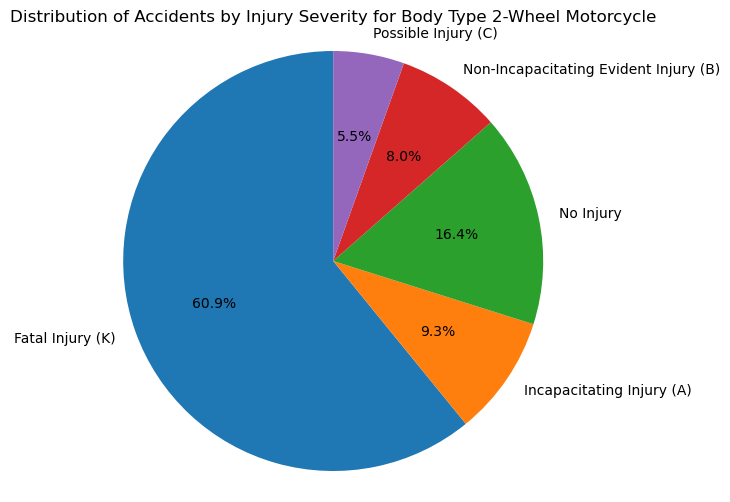

In [85]:
# Usage example
body_type = '2-Wheel Motorcycle'  # Example body type, you can replace it with any valid body type
analyze_by_body_type_and_severity(vehicle_severity_df, body_type, 6)

### While 2-Wheel Motorcycle vehicle occupants face the probability of incurring a fatal injury of around 60.9 percent of the time. This is a huge increase from Straight Truck (> 26,000 lbs) vehicles 

In [86]:
# Define the mapping for person type codes
person_type_mapping = {
    1: "Driver of a Motor Vehicle In-Transport",
    2: "Passenger of a Motor Vehicle In-Transport",
    3: "Occupant of a Motor Vehicle Not In-Transport",
    4: "Occupant of a Non-Motor Vehicle Transport Device",
    5: "Pedestrian",
    6: "Bicyclist",
    7: "Other Cyclist",
    8: "Person on Personal Conveyances",
    9: "Unknown Occupant Type in a Motor Vehicle In-Transport",
    10: "Persons in/on Buildings",
    11: "Person on Motorized Personal Conveyance",
    12: "Person on Non-Motorized Personal Conveyance",
    13: "Person on Personal Conveyance, Unknown if Motorized or Non-Motorized",
    19: "Unknown Type of Non-Motorist",
}

# Create a UDF for mapping person type codes to names
person_type_mappings = create_mapping_udf(person_type_mapping)

# Add a mapped person_type_name column to the persons DataFrame
persons = persons.withColumn("PERSON_TYPE_NAME", person_type_mappings(F.col("PER_TYP").cast("int")))

# Join the tables and include the person type names
selected_columns_analysis = (
    vehicles.join(accidents, "ST_CASE")  # Join vehicle and accident data on ST_CASE
    .join(persons, ["ST_CASE", "VEH_NO"])  # Join with persons data on ST_CASE and VEH_NO
    .select("WEATHER_NAME", "BODY_TYP", "ROUTE","ROUTENAME", "PER_TYP", "PERSON_TYPE_NAME", "INJ_SEV", "FATALS")  # Include the mapped person_type_name
)

# Show the resulting DataFrame schema and the first few rows
selected_columns_analysis.printSchema()
selected_columns_analysis.show()


root
 |-- WEATHER_NAME: string (nullable = true)
 |-- BODY_TYP: integer (nullable = true)
 |-- ROUTE: integer (nullable = true)
 |-- ROUTENAME: string (nullable = true)
 |-- PER_TYP: string (nullable = true)
 |-- PERSON_TYPE_NAME: string (nullable = true)
 |-- INJ_SEV: string (nullable = true)
 |-- FATALS: integer (nullable = true)



+------------+--------+-----+--------------------+-------+--------------------+-------+------+
|WEATHER_NAME|BODY_TYP|ROUTE|           ROUTENAME|PER_TYP|    PERSON_TYPE_NAME|INJ_SEV|FATALS|
+------------+--------+-----+--------------------+-------+--------------------+-------+------+
|       Clear|       4|    2|        U.S. Highway|      1|Driver of a Motor...|      4|     1|
|       Clear|       4|    2|        U.S. Highway|      2|Passenger of a Mo...|      2|     1|
|       Clear|       4|    3|       State Highway|      1|Driver of a Motor...|      4|     1|
|       Clear|      15|    2|        U.S. Highway|      1|Driver of a Motor...|      9|     1|
|      Cloudy|      15|    2|        U.S. Highway|      1|Driver of a Motor...|      4|     1|
|      Cloudy|      31|    3|       State Highway|      1|Driver of a Motor...|      0|     1|
|      Cloudy|       4|    3|       State Highway|      1|Driver of a Motor...|      4|     1|
|       Clear|      21|    4|         County Road|

In [87]:
def analyze_injury_severity_and_fatalities(df, weather, body_typ, route):
    """
    Analyzes injury severity and fatalities by person type for specific conditions.

    Parameters:
    - df (DataFrame): Input Spark DataFrame containing accident data.
    - weather (int): Weather condition to filter the data by.
    - body_typ (int): Vehicle body type to filter the data by.
    - route (int): Route type to filter the data by.

    Returns:
    - dict: Summary statistics including total records, fatalities count, and fatality percentage.
    - pd.DataFrame: A Pandas DataFrame with detailed injury severity and fatality counts.
    """
    
    # Filter the DataFrame based on the provided conditions
    filtered_df = df.filter(
        (df['WEATHER_NAME'] == weather) & 
        (df['BODY_TYP'] == body_typ) & 
        (df['ROUTE'] == route) &
        (df['PER_TYP'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 19]))  # Consider valid Person Types
    )
    
#     print(filtered_df.head())
    
    # Count the total number of records for the given conditions
    total_count = filtered_df.count()
    
    if total_count == 0:
        print("No data available for the given conditions.")
        return None, None

    # Group by PERSON_TYPE and INJ_SEV, and count occurrences
    injury_counts = filtered_df.groupBy('PERSON_TYPE_NAME', 'INJ_SEV').count().orderBy('PERSON_TYPE_NAME', 'INJ_SEV')
    
    # Group by PERSON_TYPE and count fatalities (FATALS > 0)
    fatality_counts = (
        filtered_df.filter(filtered_df['FATALS'] > 0)
        .groupBy('PERSON_TYPE_NAME').count()
        .withColumnRenamed('count', 'Fatalities')
    )
    
    # Join injury severity counts with fatality counts on PER_TYP
    result_df = injury_counts.join(fatality_counts, on='PERSON_TYPE_NAME', how='left')
    
    # Calculate fatality percentages
    result_df = result_df.withColumn('Fatality_Percentage', F.col('Fatalities') / total_count * 100)
    
    # Convert to Pandas DataFrame for easier analysis
    result_pandas = result_df.toPandas()

    # Summary statistics
    summary = {
        "Total Records": total_count,
        "Fatalities Count": result_df.select('Fatalities').agg({'Fatalities': 'sum'}).collect()[0][0],
        "Fatality Percentage": result_df.select('Fatality_Percentage').agg({'Fatality_Percentage': 'avg'}).collect()[0][0]
    }
    
    # Plot the data
    plt.figure(figsize=(12, 8))
    sns.barplot(x='PERSON_TYPE_NAME', y='count', hue='INJ_SEV', data=result_pandas, palette='viridis')
    plt.title('Injury Severity by Person Type')
    plt.xlabel('Person Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Injury Severity', loc='upper right')
    plt.show()
    
    return summary, result_pandas


### This can help inform travel advisories by identifying patterns and risks associated with specific conditions.
### Filtering data by weather conditions and route types, the function highlights how certain conditions (e.g., heavy rain or high-speed routes) impact injury severity and fatalities. This enables targeted advisories for hazardous conditions.


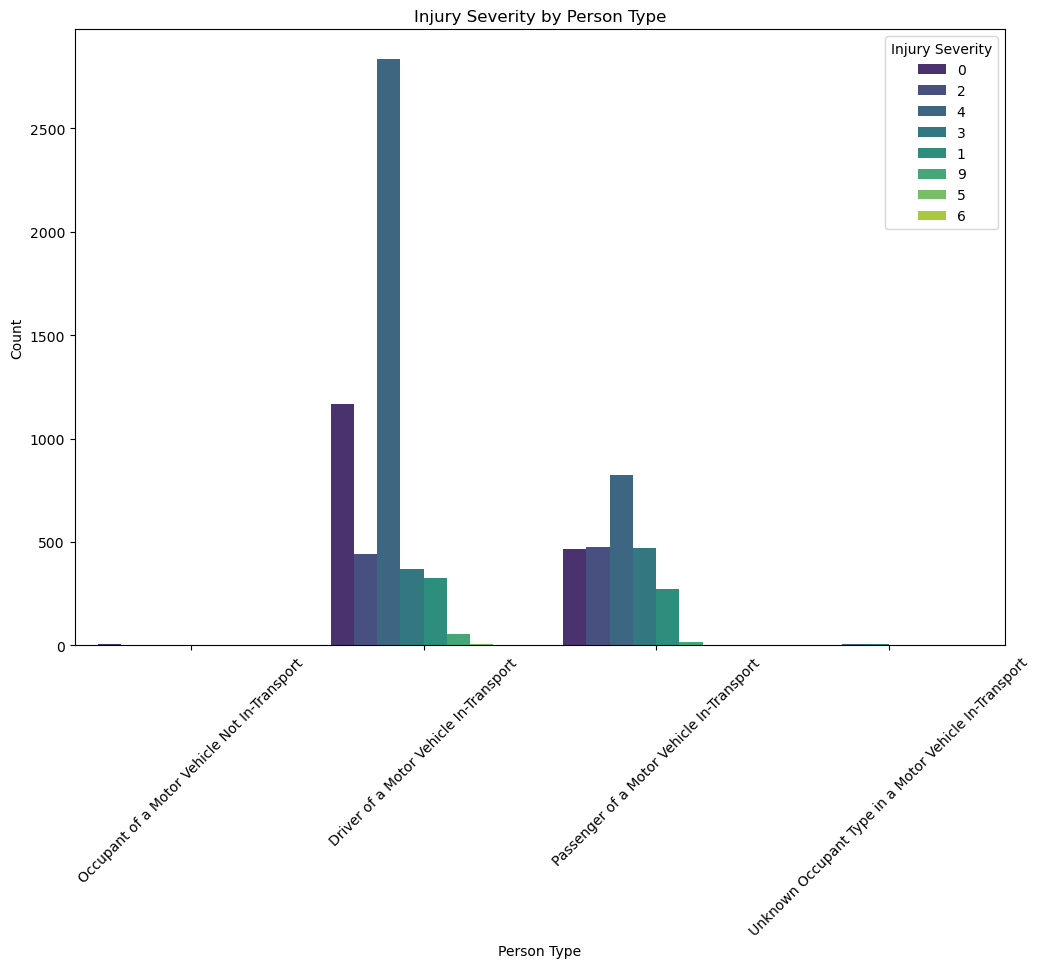

In [88]:
body_type = 2
weather = 'Clear'
route_type = 1
summary, result_df = analyze_injury_severity_and_fatalities(selected_columns_analysis, weather, body_type, route_type)



### This function filters accident data based on weather, vehicle body type, and route, then analyzes injury severity and fatalities by person type.

In [89]:
rollover_labels = {
    0: "No Rollover",
    1: "First Event",
    2: "Subsequent Event",
    3: "Rollover",
    8: "Not Applicable",
    9: "Rollover, Unknown Type"
}

# Use the existing create_mapping_udf to create the rollover label UDF
rollover_mapping_udf = create_mapping_udf(rollover_labels)

In [90]:
vehicles = vehicles.withColumn("ROLLOVER_LABEL", rollover_mapping_udf(F.col("ROLLOVER").cast("int"))).cache()
print(vehicles.head())

Row(ST_CASE=1510001.0, VEH_NO='1', NUMOCCS='1', HIT_RUN=0, MOD_YEAR=2003, MAKE=12, BODY_TYP=31, TRAV_SP=55, ROLLOVER=0, IMPACT1=12, DEFORMED=6, FIRE_EXP=0, DEATHS=1, ROLLOVER_LABEL='No Rollover')


In [91]:
# Assuming 'vehicles', 'accidents', and 'persons' are pre-loaded DataFrames

# Join vehicle, accident, and persons data on 'ST_CASE' and 'VEH_NO'
selected_columns_analysis = (
    vehicles.join(accidents, "ST_CASE")  # Join vehicle and accident data on ST_CASE
    .join(persons, ["ST_CASE", "VEH_NO"])  # Join with persons data on ST_CASE and VEH_NO
    .select("WEATHER", "WEATHER_NAME","BODY_TYP","ROUTENAME", "PER_TYP", "INJ_SEV", "FATALS", "ROLLOVER", "ROLLOVER_LABEL")
)

# Show the schema of the resulting DataFrame
selected_columns_analysis.printSchema()

# Show the first few rows of the resulting DataFrame
selected_columns_analysis.show(5)


root
 |-- WEATHER: integer (nullable = true)
 |-- WEATHER_NAME: string (nullable = true)
 |-- BODY_TYP: integer (nullable = true)
 |-- ROUTENAME: string (nullable = true)
 |-- PER_TYP: string (nullable = true)
 |-- INJ_SEV: string (nullable = true)
 |-- FATALS: integer (nullable = true)
 |-- ROLLOVER: integer (nullable = true)
 |-- ROLLOVER_LABEL: string (nullable = true)



+-------+------------+--------+-------------+-------+-------+------+--------+--------------+
|WEATHER|WEATHER_NAME|BODY_TYP|    ROUTENAME|PER_TYP|INJ_SEV|FATALS|ROLLOVER|ROLLOVER_LABEL|
+-------+------------+--------+-------------+-------+-------+------+--------+--------------+
|      1|       Clear|       4| U.S. Highway|      1|      4|     1|       1|   First Event|
|      1|       Clear|       4| U.S. Highway|      2|      2|     1|       1|   First Event|
|      1|       Clear|       4|State Highway|      1|      4|     1|       0|   No Rollover|
|      1|       Clear|      15| U.S. Highway|      1|      9|     1|       0|   No Rollover|
|     10|      Cloudy|      15| U.S. Highway|      1|      4|     1|       1|   First Event|
+-------+------------+--------+-------------+-------+-------+------+--------+--------------+
only showing top 5 rows



In [92]:

def rollover_type_counts(df, weather, body_typ, route):
    # Filter the DataFrame based on the provided conditions (weather, body_typ, and route)
    filtered_df = df.filter(
        (df['WEATHER_NAME'] == weather) & 
        (df['BODY_TYP'] == body_typ) & 
        (df['ROUTENAME'] == route)
    )
    
    # Count the total number of records for the given conditions
    total_count = filtered_df.count()
    
    if total_count == 0:
        print("No data available for the given conditions.")
        return None, None
    
    # Add the mapped rollover label column using the UDF
    filtered_df = filtered_df.withColumn('ROLLOVER_LABEL', rollover_mapping_udf(F.col('ROLLOVER')))
    
    # Group by ROLLOVER and ROLLOVER_LABEL columns, and count occurrences of each type
    rollover_count_df = filtered_df.groupBy('ROLLOVER', 'ROLLOVER_LABEL').count().orderBy('ROLLOVER')
    
    # Convert the Spark DataFrame to Pandas for easier handling and further analysis
    rollover_count_pandas = rollover_count_df.toPandas()
    
    # Calculate the percentage for each rollover type
    rollover_count_pandas['Percentage'] = (rollover_count_pandas['count'] / total_count) * 100
    
    # Print the rollover count table with labels and percentages
    print(f"Analysis for Weather: {weather}, Vehicle Type: {vehicle_body_types[body_typ]}, Route: {route}")
    print("Rollover Count by Type (with Percentages):")
    print(rollover_count_pandas[['ROLLOVER', 'ROLLOVER_LABEL', 'count', 'Percentage']])
    
    # Prepare the result with the total count and percentages
    result = {
        "Total Records": total_count,
    }
    
    return result, rollover_count_pandas



### This function calculates the count and percentage distribution of different rollover types, classifying them using a predefined mapping.

### This analysis aids in issuing targeted safety advisories to mitigate rollover-related hazards and knowing about risks related with using each vehicle.


Analysis for Weather: Clear, Vehicle Type: 2-Door Sedan/Coupe, Route: Interstate
Rollover Count by Type (with Percentages):
   ROLLOVER          ROLLOVER_LABEL  count  Percentage
0         0             No Rollover   6690   76.667431
1         1             First Event   1616   18.519367
2         2        Subsequent Event    264    3.025441
3         9  Rollover, Unknown Type    156    1.787761
Total Records: 8726


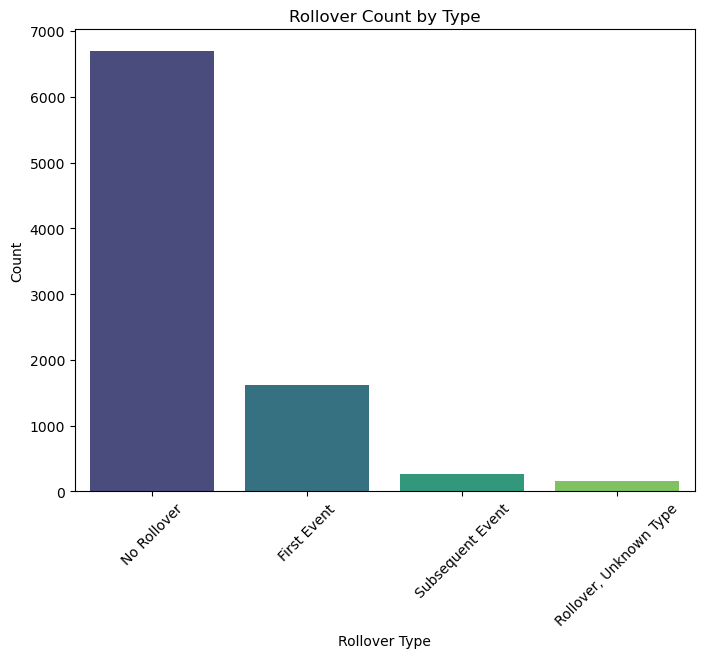

In [93]:
result, rollover_df = rollover_type_counts(selected_columns_analysis, weather='Clear', body_typ=2, route='Interstate')

# Print the analysis results
if result:
    print(f"Total Records: {result['Total Records']}")

    # Plot the data
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Plot the rollover count by type
    plt.figure(figsize=(8, 6))
    sns.barplot(x='ROLLOVER_LABEL', y='count', data=rollover_df, hue='ROLLOVER_LABEL', palette='viridis')
    plt.title('Rollover Count by Type')
    plt.xlabel('Rollover Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
